<a href="https://colab.research.google.com/github/visualbit/03MIAR---Algoritmos---de---Optimizacion/blob/main/Actividad_C1_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

**Carolina Londoño Idárraga**

**Aprendizaje Supervisado**

#### 0) Cargar una de las imágenes histológicas

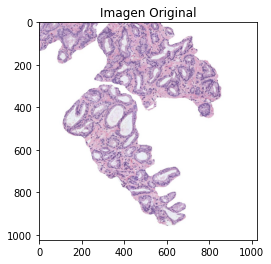

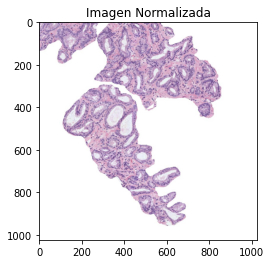

In [134]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.

from skimage import io, color, filters, morphology, segmentation, measure
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.morphology import binary_fill_holes
from scipy import ndimage
from skimage.measure import regionprops





# Leer la imagen en formato RGB
img = io.imread('images/histo_2.jpg')
# Visualizar la imagen
plt.title("Imagen Original")
plt.imshow(img)
plt.show()

# Normalizar la imagen para que los píxeles estén en el rango [0, 1]
img_normalized = img / 255

# Visualizar la imagen
plt.title("Imagen Normalizada")
plt.imshow(img_normalized)
plt.show()



#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

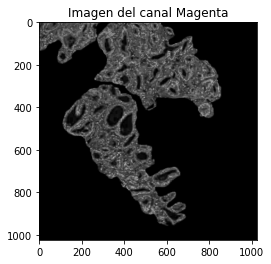

In [135]:
from skimage.color.colorconv import convert_colorspace
# Convertir la imagen a formato CMYK

def convert_to_CMYK(rgb_p):
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(rgb_p, axis=2)
        C = (1-rgb_p[:,:,0] - K)/(1-K)
        M = (1-rgb_p[:,:,1] - K)/(1-K)
        Y = (1-rgb_p[:,:,2] - K)/(1-K)
    CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
    return CMYK

img_cmyk = convert_to_CMYK(img_normalized)

# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
magenta_channel = img_cmyk[:, :, 1]

# Visualizar la imagen del canal magenta
plt.title("Imagen del canal Magenta")
plt.imshow(magenta_channel, cmap='gray')
plt.show()



#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular


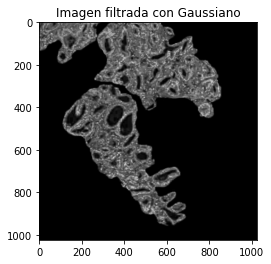

[0 1]


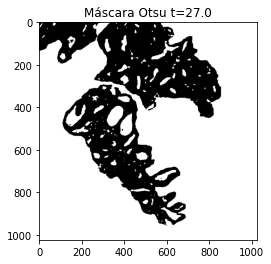

In [136]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

img_gaus = cv2.GaussianBlur (magenta_channel, (5, 5), 0)
plt.imshow(img_gaus, cmap='gray')
plt.title('Imagen filtrada con Gaussiano')

plt.show()

# Convertir la imagen al rango [0-255] en formato "uint8"
img_uint8 = (img_gaus).astype(np.uint8)

# Aplicar el método de Otsu para obtener el umbral óptimo
t, mask=cv2.threshold(img_uint8,0,1,cv2.THRESH_OTSU)
print(np.unique(mask))
binaria=np.where(mask==0,1,0)


# Visualizar la máscara resultante
plt.imshow(binaria, cmap='gray')
plt.title('Máscara Otsu t='+str(t))
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

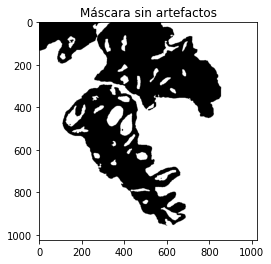

In [137]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

# Eliminar objetos cuya área sea menor a 300 píxeles
img_clean = morphology.remove_small_objects(binaria.astype(bool), min_size=300)

# Visualizar la máscara resultante
plt.title('Máscara sin artefactos')
plt.imshow(img_clean, cmap='gray')
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

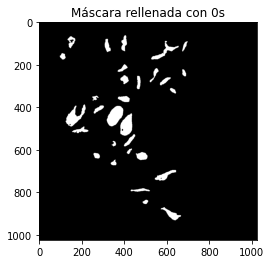

In [138]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

mask_cleaned = img_clean.copy()
mask_cleaned = mask_cleaned.astype('uint8')
h, w = mask_cleaned.shape
ref = np.zeros((h+2, w+2), np.uint8)


cv2.floodFill(mask_cleaned, ref, (0,0), 0) 
cv2.floodFill(mask_cleaned, ref, (1000,1000), 0) 

plt.title('Máscara rellenada con 0s')
plt.imshow(mask_cleaned,cmap='gray')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

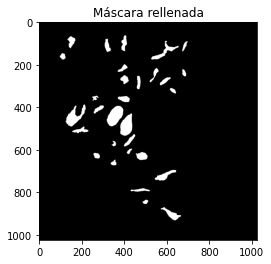

In [139]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
mask_filled = binary_fill_holes(mask_cleaned)


# Visualizar la máscara resultante
plt.title('Máscara rellenada')
plt.imshow(mask_filled, cmap='gray')
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

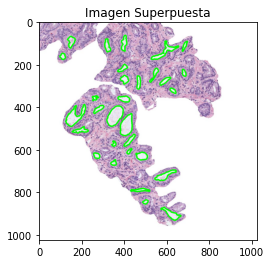

In [140]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta


# Crear una copia de la imagen original
img_contours = img.copy()

# Dibujar los contornos en verde sobre la imagen copiada
contours,_ = cv2.findContours(mask_filled.astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_contours,contours,-1,(0,255,0),6)


# Visualizar la imagen superpuesta
plt.title('Imagen Superpuesta')
plt.imshow(img_contours,cmap='gray')
plt.show()



#### 7) Identificar y cropear el lumen más grande

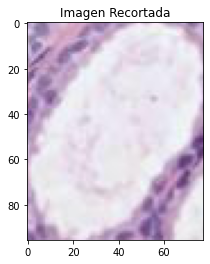

In [141]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.

# Etiquetar los objetos conectados en la imagen binaria
labels, num_labels = ndimage.label(mask_cleaned)

# Calcular las propiedades de cada objeto
props = regionprops(labels)

# Encontrar el lumen con mayor área
max_area = 0
max_label = None

for i in range(num_labels):
    if props[i].area > max_area:
        max_area = props[i].area
        max_label = i

# Obtener las coordenadas del lumen más grande
min_row, min_col, max_row, max_col = props[max_label].bbox

# Recortamos la imagen original para obtener únicamente el lumen seleccionado
cropped_image = img[min_row:max_row, min_col:max_col, :]

# Visualizar el lumen cropeado
plt.title('Imagen Recortada')
plt.imshow(cropped_image)
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [142]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad


# Etiquetar regiones conectadas en la máscara del lumen
label_img = measure.label(mask_cleaned)

# Encontrar la región correspondiente al lumen más grande
region_props = measure.regionprops(label_img)
max_area = 0
max_region = None
for region in region_props:
    if region.area > max_area:
        max_area = region.area
        max_region = region

# Calcular características del lumen más grande
area = max_region.area
bbox_area = max_region.bbox_area
convex_area = max_region.convex_area
eccentricity = max_region.eccentricity
equivalent_diameter = max_region.equivalent_diameter
extent = max_region.extent
feret_diameter = max_region.feret_diameter_max
major_axis_length = max_region.major_axis_length
minor_axis_length = max_region.minor_axis_length
orientation = max_region.orientation
perimeter = max_region.perimeter
solidity = max_region.solidity
compactness = (4 * np.pi * area) / max_region.perimeter**2

# Redondear valores a 4 decimales
area = round(area, 4)
bbox_area = round(bbox_area, 4)
convex_area = round(convex_area, 4)
eccentricity = round(eccentricity, 4)
equivalent_diameter = round(equivalent_diameter, 4)
extent = round(extent, 4)
feret_diameter = round(feret_diameter, 4)
major_axis_length = round(major_axis_length, 4)
minor_axis_length = round(minor_axis_length, 4)
orientation = round(orientation, 4)
perimeter = round(perimeter, 4)
solidity = round(solidity, 4)
compactness = round(compactness, 4)

# Imprimir valores de las características
print("Área:", area)
print("Área de la bounding box:", bbox_area)
print("Área convexa:", convex_area)
print("Excentricidad:", eccentricity)
print("Diámetro equivalente:", equivalent_diameter)
print("Extensión:", extent)
print("Diámetro Feret:", feret_diameter)
print("Longitud del eje mayor:", major_axis_length)
print("Longitud del eje menor:", minor_axis_length)
print("Orientación:", orientation)
print("Perímetro:", perimeter)
print("Solidez:", solidity)
print("Compacidad:", compactness)




Área: 4881
Área de la bounding box: 7488
Área convexa: 5013
Excentricidad: 0.835
Diámetro equivalente: 78.8333
Extensión: 0.6518
Diámetro Feret: 105.6788
Longitud del eje mayor: 106.5053
Longitud del eje menor: 58.5976
Orientación: -0.5613
Perímetro: 280.9777
Solidez: 0.9737
Compacidad: 0.7769
